In [48]:
import time
import matplotlib.pyplot as plt
import torch
import numpy as np
from laplacian_py import laplacian_solver
print(laplacian_solver.__dir__())

res = 50
max_val = .8*res//3

values = max_val*(.1*torch.rand((res, res),dtype=torch.float32, device='cuda')+1)
boundary_conditions = torch.zeros((res,res),dtype=torch.float32, device='cuda')
boundary_types = torch.zeros((res,res),dtype=torch.float32, device='cuda')


obj1_ind1 = int(res*18/30)
obj1_ind2 = int(res*2/3)
obj1_ind3 = int(res*0)
obj1_ind4 = int(res*2/3)
boundary_conditions[obj1_ind1:obj1_ind2, obj1_ind3:obj1_ind4] = max_val
boundary_types[obj1_ind1:obj1_ind2, obj1_ind3:obj1_ind4] = 1.0

obj2_ind1 = int(res*3/12)
obj2_ind2 = int(res*4/12)
obj2_ind3 = int(res*1/3)
obj2_ind4 = int(res*28/30)
boundary_conditions[obj2_ind1:obj2_ind2, obj2_ind3:obj2_ind4] = max_val
boundary_types[obj2_ind1:obj2_ind2, obj2_ind3:obj2_ind4] = 1.0

# boundary_conditions[2*60:2*80, 2*60:2*80] = 0
# boundary_types[2*60:2*80, 2*60:2*80] = 1.0

ind1 = int(res*2/30)
ind2 = int(res*2/30)
boundary_conditions[ind1, ind2] = 0.0
boundary_types[ind1, ind2] = 1.0

ind1 = int(res*6/30)
ind2 = int(res*22/30)
boundary_conditions[ind1, ind2] = 0.0
boundary_types[ind1, ind2] = 1.0

# inds = np.random.rand(boundary_conditions.shape[0], boundary_conditions.shape[1]) > .999
# boundary_conditions[inds] = 100
# boundary_types[inds] = 1.0

def get_edge_inds(grid_size, dim_index):
    offset = 1
    XYZ = [np.linspace(0, s-1, s, dtype=np.int32) for s in grid_size]
    out = np.meshgrid(*XYZ)
    tmp = np.vstack([val.flatten() for val in out])
    inds1 = tmp[dim_index, :] == 0 + offset
    inds2 = tmp[dim_index, :] == grid_size[dim_index] -1 -offset
    inds = np.any(np.vstack([inds1, inds2]), axis=0)
    return np.reshape(inds, grid_size) 

# edge_inds_x = get_edge_inds(values.shape, 0)
# boundary_conditions[edge_inds_x] = 40
# boundary_types[edge_inds_x] = 1 # flux x

# edge_inds_y = get_edge_inds(values.shape, 1)
# boundary_conditions[edge_inds_y] = 40
# boundary_types[edge_inds_y] = 1 # flux y

XYZ = [np.linspace(0, 1, res, dtype=np.float32) for _ in range(2)]
X, Y = np.meshgrid(*XYZ)
# cost = .005*torch.tensor(10*(1-X)*(1-Y),dtype=torch.float32, device='cuda')
cost = .005*torch.ones(res,res,dtype=torch.float32, device='cuda')
safe = res//15
cost[max(obj1_ind1-safe, 0):min(obj1_ind2+safe, res-1), max(obj1_ind3-safe, 0):min(obj1_ind4+safe, res-1)] = .1
cost[max(obj2_ind1-safe, 0):min(obj2_ind2+safe, res-1), max(obj2_ind3-safe, 0):min(obj2_ind4+safe, res-1)] = .1




# start = time.time()
# x = np.zeros((100,100),dtype=np.float32)
# for i in range(100000):
#     x = x + 1
# end = time.time()
# print(end - start)




['__name__', '__doc__', '__package__', '__loader__', '__spec__', 'forward', 'backward', '__file__']


In [49]:
from torch.autograd import Function
from torch.autograd.function import once_differentiable

class LaplacianSolver(Function):
    @staticmethod
    def forward(ctx, V: torch.Tensor, C: torch.Tensor):
        X = torch.stack([V, boundary_types, boundary_conditions, C], axis=2)
        intermediate = [C] 
        for i in range(500):
            laplacian_solver.forward(X)
            intermediate.append(X[:, :, 0].clone())
        ctx.save_for_backward(*intermediate)
        out = X[:, :, 0].clone()    
        
        return out
    
    @staticmethod
    @once_differentiable
    def backward(ctx, dL_dout):
        # dL_dX how loss change with output X
        intermediate = ctx.saved_tensors
        print(f"dL_dout: {dL_dout.shape}")
        #         print(f"intermediate: {len(intermediate)}")
        grid_size = intermediate[0].shape
        print(f"grid_size: {grid_size}")

        dL_dV = torch.zeros(grid_size, dtype=torch.float32, device='cuda')
        dL_dC = torch.zeros(grid_size, dtype=torch.float32, device='cuda')
        
        C = intermediate[0]
        for V in intermediate[1:]:
            X = torch.stack([V, boundary_types, boundary_conditions, C], axis=2)
#             print(f"X, dL_dout, dL_dV, dL_dC: {X.shape} {dL_dout.shape} {dL_dV.shape} {dL_dC.shape}")
            laplacian_solver.backward(X, dL_dout, dL_dV, dL_dC)
      
        
        return dL_dV, dL_dC

V =  values
C =  cost

0.0039899349212646484
dL_dout: torch.Size([50, 50])
grid_size: torch.Size([50, 50])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -9.5604, -9.5517,  ..., -5.6089, -5.5797,  0.0000],
        [ 0.0000, -9.5517, -9.6071,  ..., -5.5956, -5.5653,  0.0000],
        ...,
        [ 0.0000, 16.6692, 16.4017,  ...,  8.1041,  8.2074,  0.0000],
        [ 0.0000, 16.9606, 16.7582,  ...,  8.2409,  8.3740,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.         

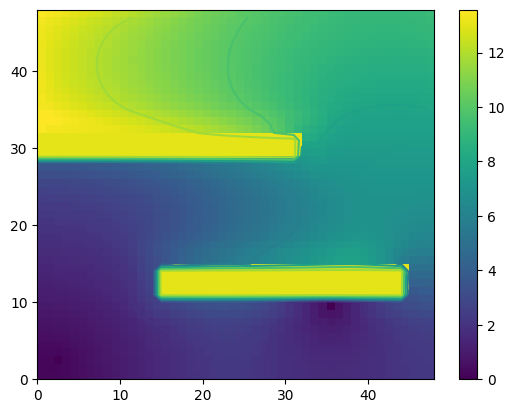

In [53]:
V = V.detach().requires_grad_(True)
C = C.detach().requires_grad_(True)
layer = LaplacianSolver()
forward = layer.apply
start = time.time()
out = forward(V, C)

end = time.time()
print(end - start)

loss = torch.sum((out-5)**2)
loss.backward()

print(C.grad)
import sys
np.set_printoptions(threshold=sys.maxsize)
# print(V.cpu().detach().numpy())
print(V.grad.cpu().numpy())
V = out.detach()


z = V.cpu().detach().numpy()[1:-1, 1:-1]
plt.pcolormesh(z)
plt.colorbar()
plt.contour(z)
plt.show()

# print(torch.cuda.memory_summary() )

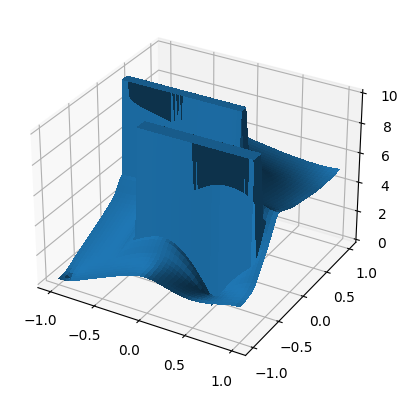

In [35]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X = np.linspace(-1, 1, z.shape[0])
Y = np.linspace(-1, 1, z.shape[1])
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X,Y,z,linewidth=0, antialiased=False)

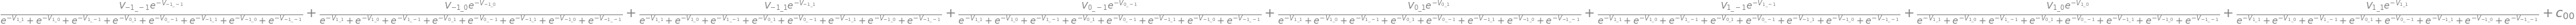

In [5]:
import sympy
from sympy import *

V_s = [symbols('V_{'+f'{i}\_{j}' +'}') for i in [-1,0,1] for j in [-1,0,1] if i!=0 or j!=0]
# V = symbols(f'V00')
c_s = symbols(f'c00')
init_printing(use_unicode=True, wrap_line=False)

expression = c_s + sum([vi*exp(-vi)/(sum([exp(-vj) for vj in V_s])) for vi in V_s])
expression

d/dV_{-1\_-1}


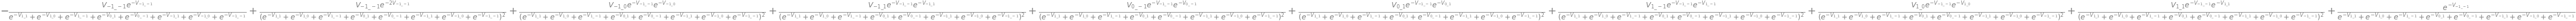

In [6]:
print(f'd/d{V_s[0].name}')
derivative = diff(expression, V_s[0])
derivative

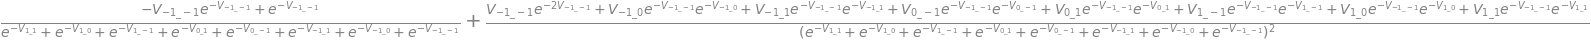

In [7]:
# factor = 1/(sum([exp(-vj) for vj in V_s]))
factor = sum([exp(-vj) for vj in V_s])
derivative = sympy.collect(derivative, factor)
# derivative = derivative.simplify()
# derivative = derivative.simplify()
# factor
derivative

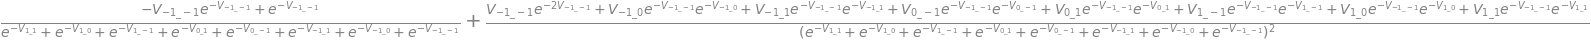

In [8]:
derivative

In [9]:
print('d/dc')
diff(expression, c_s)

d/dc


In [12]:
max_val